# Example usage

Here we will demonstrate how to use the `stepsel` package for stepwise selection of variables in a regression model and how to prepare categorical data for such a model.

In [1]:
# Importing the packages
import stepsel
import numpy as np
import statsmodels.api as sm

## Load the data
First we load the data and take a look at the first few rows. It is soccer data from Czech First League.

In [2]:
dt = stepsel.datasets.load_soccer_data()
print(dt.shape, dt.columns)

(518, 24) Index(['match_id', 'match_datetime', 'team', 'hga', 'team_opp', 'goals',
       'goals_opp', 'yellow', 'yellow_opp', 'red', 'red_opp', 'penalty',
       'penalty_opp', 'fouls', 'fouls_opp', 'attacks', 'attacks_opp',
       'dangerous_attacks', 'dangerous_attacks_opp', 'ref_interv',
       'ref_interv_opp', 'ref_interv_per_attack', 'ref_interv_per_attack_opp',
       'ref_interv_per_attack_diff'],
      dtype='object')


In [3]:
dt.head()

,match_id,match_datetime,team,hga,team_opp,goals,goals_opp,yellow,yellow_opp,red,...,fouls_opp,attacks,attacks_opp,dangerous_attacks,dangerous_attacks_opp,ref_interv,ref_interv_opp,ref_interv_per_attack,ref_interv_per_attack_opp,ref_interv_per_attack_diff
0,1,2023-05-14 18:00:00,Bohemians,H,Slovácko,0.0,0.0,2,2,0,...,12.0,117.0,142.0,71.0,88.0,20.0,18.0,0.140845,0.153846,-0.013001
1,2,2023-05-14 15:00:00,Jablonec,H,Baník Ostrava,1.0,1.0,1,1,0,...,11.0,90.0,116.0,74.0,58.0,14.0,22.0,0.120690,0.244444,-0.123755
2,3,2023-05-14 15:00:00,Teplice,H,Zlín,2.0,1.0,4,4,0,...,14.0,118.0,134.0,54.0,62.0,30.0,26.0,0.223881,0.220339,0.003542
3,4,2023-05-14 15:00:00,Zbrojovka Brno,H,Pardubice,0.0,2.0,1,2,0,...,14.0,99.0,126.0,57.0,76.0,17.0,36.0,0.134921,0.363636,-0.228716
4,5,2023-05-13 18:00:00,Sparta Praha,H,Slavia Praha,3.0,2.0,1,2,0,...,15.0,87.0,145.0,47.0,94.0,15.0,29.0,0.103448,0.333333,-0.229885


## Binning the data
There are two ways to bin data in `stepsel` package: by specifying the cut points or optimal binning. We will demonstrate both.

### By specifying the cut points

In [4]:
dt["fouls_opp_cat1"] = stepsel.binning.bin_values(dt["fouls_opp"], [8, 12, 16, 20])
dt["fouls_opp_cat1"].value_counts()

fouls_opp_cat1
(8, 12]      195
(12, 16]     167
(-Inf, 8]     84
(16, 20]      58
(20, Inf)     14
Name: count, dtype: int64

### Optimal binning
Optimal binning can be time consuming, so when the data is large, and there are many cp values, they are grouped using K-means clustering and only the best clusters are used. This process is controlled by the Flow Parameters (see the docstring).
Other parameters are used to control the scikit-learn's `DecisionTreeRegressor`, `KMeans` and `GridSearchCV`.


Starting cross-validation for 58 cp values at 15:20:32.
Estimated runtime: 0.015105549494425457 minutes.


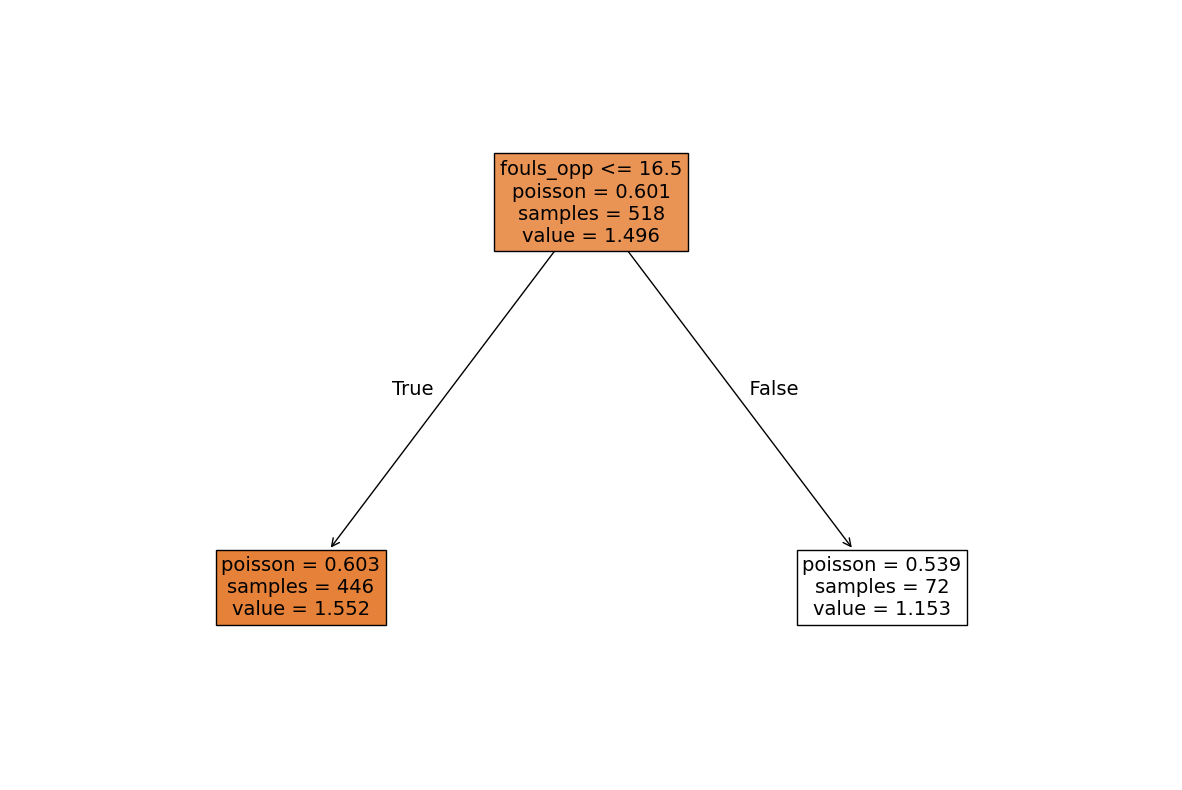

In [5]:
X = np.array(dt.loc[:, ["fouls_opp"]])
y = np.array(dt.loc[:, "goals"])

clf = stepsel.binning.optimal.OptimalBinningUsingDecisionTreeRegressor(
    criterion = 'poisson',
    scoring = "neg_mean_poisson_deviance",
    refit = "neg_mean_poisson_deviance",
    max_depth = 3
)
clf.fit(X, y) # Fit the model
clf.set_feature_names(["fouls_opp"]) # Set the feature names for the plot
clf.plot_tree((15,10)) # Plot the tree

In [6]:
# Predicting the values
dt["fouls_opp_cat2"] = clf.predict(X)
dt["fouls_opp_cat2"].value_counts()

fouls_opp_cat2
1.551570    446
1.152778     72
Name: count, dtype: int64

In [7]:
# Creating the bins
dt["fouls_opp_cat2"] = clf.bin_values(dt["fouls_opp"])
dt["fouls_opp_cat2"] = dt["fouls_opp_cat2"].astype("category")

In [8]:
# Function to get the cut points can be used for any scikit-learn tree based model
# The final tree can be obtained from the cv_fit attribute of the model Log object
stepsel.binning.helper.get_tree_cut_points(clf.Log.fit_log["cv_fit"].best_estimator_, feature_names=["fouls_opp"])

{'fouls_opp': array([16.5])}

## Setting the reference category
You can order any number of teams, the first one will be the reference category

In [9]:
dt["hga"] = stepsel.modeling.prep.relevel_categorical_variable(dt["hga"], ["H"])
dt["team"] = stepsel.modeling.prep.relevel_categorical_variable(dt["team"], ["Bohemians", "Jablonec"])
dt["team_opp"] = stepsel.modeling.prep.relevel_categorical_variable(dt["team_opp"], ["Bohemians", "Jablonec", "Teplice"])
dt["fouls_opp_cat1"] = stepsel.modeling.prep.relevel_categorical_variable(dt["fouls_opp_cat1"], ["(-Inf, 8]"])

Series is not categorical, converting to categorical.
Series is not categorical, converting to categorical.
Series is not categorical, converting to categorical.
Series is not categorical, converting to categorical.


## Stepwise selection
The most important parameters for the selection are `formula`, `include`, `slentry` and `slstay`. Specifying the formula in R-style format, the variables to always include in the model, and the significance levels of the likelihood ratio test for entering and staying in the model.

In [10]:
# Parameters for the model
formula = "goals ~ team + hga + red_opp + fouls_opp_cat1 + fouls_opp_cat2"
include = ['ref_interv_per_attack * ref_interv_per_attack_opp', "penalty"]
slentry = 0.05
slstay = 0.10
family = sm.families.Poisson()

In [11]:
# Fitting the model
model1 = stepsel.modeling.stepwise_glm.StepwiseGLM(
    formula = formula,
    data = dt,
    include = include,
    slentry = slentry,
    slstay = slstay,
    family = family
)
model1.fit()

Best entry candidates:
          feature   p_value
0            team  0.000002
1             hga  0.000609
2         red_opp  0.005159
3  fouls_opp_cat2  0.013067
4  fouls_opp_cat1  0.060894
>> team entered the model.

Best removal candidates:
  feature   p_value
0    team  0.000002
>> No feature removed from the model.

Best entry candidates:
          feature   p_value
0             hga  0.000608
1         red_opp  0.004282
2  fouls_opp_cat2  0.045388
3  fouls_opp_cat1  0.160092
>> hga entered the model.

Best removal candidates:
  feature   p_value
0     hga  0.000608
1    team  0.000002
>> No feature removed from the model.

Best entry candidates:
          feature   p_value
0         red_opp  0.003997
1  fouls_opp_cat2  0.022037
2  fouls_opp_cat1  0.052854
>> red_opp entered the model.

Best removal candidates:
   feature   p_value
0  red_opp  0.003997
1      hga  0.000569
2     team  0.000002
>> No feature removed from the model.

Best entry candidates:
          feature   p_valu

### Refitting the model
After the selection it is possible to specify different model formula and use the Log of the previously fitted model to speed up the selection. This is useful when the data is large and the selection is time consuming. The same partial models during the selection won't be fitted again.
**Only use this functionality when the data has not changed!**

In [12]:
# The new formula including the team_opp variable
formula_new = "goals ~ team + hga + red_opp + fouls_opp_cat1 + fouls_opp_cat2 + team_opp"
model2 = stepsel.modeling.stepwise_glm.StepwiseGLM(
    formula = formula_new,
    data = dt,
    include = include,
    slentry = slentry,
    slstay = slstay,
    model_fit_log = model1.model_fit_log, # Use the previous model fit Log object
    family = sm.families.Poisson()
)
model2.fit()

Best entry candidates:
          feature   p_value
0            team  0.000002
1        team_opp  0.000284
2             hga  0.000609
3         red_opp  0.005159
4  fouls_opp_cat2  0.013067
>> team entered the model.

Best removal candidates:
  feature   p_value
0    team  0.000002
>> No feature removed from the model.

Best entry candidates:
          feature   p_value
0        team_opp  0.000392
1             hga  0.000608
2         red_opp  0.004282
3  fouls_opp_cat2  0.045388
4  fouls_opp_cat1  0.160092
>> team_opp entered the model.

Best removal candidates:
    feature   p_value
0  team_opp  0.000392
1      team  0.000003
>> No feature removed from the model.

Best entry candidates:
          feature   p_value
0             hga  0.000621
1         red_opp  0.005264
2  fouls_opp_cat2  0.078540
3  fouls_opp_cat1  0.131029
>> hga entered the model.

Best removal candidates:
    feature   p_value
0       hga  0.000621
1  team_opp  0.000397
2      team  0.000003
>> No feature removed

In [13]:
# Print the summary of the final model. The extracted model is statsmodels object.
final_model = model2.current_model
print(final_model.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                  goals   No. Observations:                  518
Model:                            GLM   Df Residuals:                      483
Model Family:                 Poisson   Df Model:                           34
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -736.76
Date:                Tue, 03 Sep 2024   Deviance:                       486.00
Time:                        15:20:35   Pearson chi2:                     405.
No. Iterations:                     5   Pseudo R-squ. (CS):             0.2316
Covariance Type:            nonrobust                                         
                                                        coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------

## Prepering model matrix for other models
The `stepsel` package can be used to prepare the model matrix for other models. The `prepare_model_matrix` function is used for this purpose using the convienient `formula` syntax.
Interaction terms of two variables are supported.

In [14]:
# Prepare the model matrix
formula = "goals ~ team + hga * penalty"
y, X, feature_ids = stepsel.modeling.prep.prepare_model_matrix(formula, dt)

## Fit `statsmodels` model with prepared model matrix using `stepsel`

In [15]:
# Train-test split based on the match_id
train_filter = dt["match_id"] <= 200
y_train = y[train_filter]
X_train = X.loc[train_filter,:].copy()
y_test = y[~train_filter]
X_test = X.loc[~train_filter,:].copy()

In [16]:
# Fit the model
model3 = sm.GLM(endog = y_train,
              exog = X_train,
              family = family)
model3 = model3.fit()
print(model3.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                  goals   No. Observations:                  400
Model:                            GLM   Df Residuals:                      382
Model Family:                 Poisson   Df Model:                           17
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -593.90
Date:                Tue, 03 Sep 2024   Deviance:                       423.76
Time:                        15:20:35   Pearson chi2:                     369.
No. Iterations:                     5   Pseudo R-squ. (CS):             0.1442
Covariance Type:            nonrobust                                         
                             coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept                  0

## Fixing some of the variables coefficients
It is possible to fix some of the variables coefficients to a specific value using offset. This is particularly useful when the variable is a factor and one or more of its levels are not well fitted by the model.

In [17]:
# Fix some of the coefficients - use the names of the coefficients from the summary
adjusted_coeffs = {"team: Baník Ostrava": 0.00,
                   "hga: H * penalty": 0.45 
}

In [18]:
# Adjust the model matrix and offset
X_train, X_test, offset_train, offset_test = stepsel.modeling.prep.model_matrix.adjust_model_matrix([X_train, X_test], adjusted_coeffs)

In [19]:
# Fit the final model using the adjusted model matrix and offset
model_final2 = sm.GLM(endog = y_train,
              exog = X_train,
              family = family,
              offset = offset_train)
model_final2 = model_final2.fit()
print(model_final2.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                  goals   No. Observations:                  400
Model:                            GLM   Df Residuals:                      384
Model Family:                 Poisson   Df Model:                           15
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -593.96
Date:                Tue, 03 Sep 2024   Deviance:                       423.87
Time:                        15:20:36   Pearson chi2:                     370.
No. Iterations:                     5   Pseudo R-squ. (CS):             0.1189
Covariance Type:            nonrobust                                         
                             coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept                  0

## Scoring the model
The model can be scored via standard `statsmodels` API. `stepsel` package provides a `scoring_table` object, which handles the fixed variables and the offset in a straightforward way. It is also possible to generate SQL code for scoring the model in the database.

In [20]:
# Create scoring table
# Notice the fixed coefficients are also used in the scoring table
# You can also create the scoring table from csv file or pandas DataFrame.
scoring_table = stepsel.modeling.predict.ScoringTableGLM.from_glm_model(model_final2, adjusted_coeffs)
print(scoring_table)

ScoringTableGLM(scoring_table=         var1     var2        level_var1 level_var2  estimate
0   Intercept     None              None       None  0.391757
1        team     None  České Budějovice       None -0.209868
2        team     None              Zlín       None -0.182095
3        team     None    Zbrojovka Brno       None -0.381924
4        team     None    Viktoria Plzeň       None  0.147379
5        team     None           Teplice       None -0.220638
6        team     None      Sparta Praha       None  0.409163
7        team     None          Slovácko       None -0.276560
8        team     None    Slovan Liberec       None -0.168498
9        team     None      Slavia Praha       None  0.470338
10       team     None     Sigma Olomouc       None  0.037562
11       team     None         Pardubice       None -0.337274
12       team     None    Mladá Boleslav       None -0.265193
13       team     None          Jablonec       None -0.041279
14       team     None    Hradec Králové

In [21]:
# For prediction, prepare the full model matrix
y, X_full, feature_ids_full = stepsel.modeling.prep.prepare_model_matrix(formula, dt, drop_first=False)

# There is a method to predict the linear predictor of the model, which can be used to calculate the predictions
dt["preds"] = np.exp(scoring_table.predict_linear(X_full))

In [22]:
# Generate the SQL code for the model (microsoft SQL Server flavor)
print(scoring_table.sql(format=True))

 + 0.39175660628921744
 + case  when TRIM(CAST(team as varchar(999))) = 'České Budějovice' then -0.2098683563962888
 when TRIM(CAST(team as varchar(999))) = 'Zlín' then -0.18209532272001644
 when TRIM(CAST(team as varchar(999))) = 'Zbrojovka Brno' then -0.38192399630625384
 when TRIM(CAST(team as varchar(999))) = 'Viktoria Plzeň' then 0.14737941642116634
 when TRIM(CAST(team as varchar(999))) = 'Teplice' then -0.22063773340931742
 when TRIM(CAST(team as varchar(999))) = 'Sparta Praha' then 0.4091626261463453
 when TRIM(CAST(team as varchar(999))) = 'Slovácko' then -0.2765597308949614
 when TRIM(CAST(team as varchar(999))) = 'Slovan Liberec' then -0.1684980555750112
 when TRIM(CAST(team as varchar(999))) = 'Slavia Praha' then 0.4703384015175229
 when TRIM(CAST(team as varchar(999))) = 'Sigma Olomouc' then 0.037561752737359774
 when TRIM(CAST(team as varchar(999))) = 'Pardubice' then -0.33727351980242654
 when TRIM(CAST(team as varchar(999))) = 'Mladá Boleslav' then -0.2651933788212607
 

## Verifying the model
For quick verification of the model, one can use the `group_over_columns` function, which goes over the specified columns and applies the specified grouping dictionary. This is built on top of the pandas `groupby` function.

In [23]:
# Evaluate the model. Note you can evaluate any combination of variables.
vars2eval = ["team", "hga", "penalty", "fouls_opp_cat2", ["hga", "penalty"]]
evaluation_train = stepsel.tools.group_over_columns(dt.loc[train_filter,], vars2eval, {"goals": "mean", "preds": "mean" })
evaluation_test = stepsel.tools.group_over_columns(dt.loc[~train_filter,:], vars2eval, {"goals": "mean", "preds": "mean"})

In [24]:
# One can see that rather simple descriptive model fits the data reasonably well, even though it was constructed only to demonstrate the package.
# The biggest discrepancy is in matches with penalty, and for the teams of Slavia Praha and Sparta Praha. This has its reasons,
# and Czech football fans will have their own opinions on that.
print(evaluation_train, evaluation_test, sep="\n\n")

        variable_1           level_1 variable_2  level_2     goals     preds
0             team         Bohemians        NaN      NaN  1.640000  1.636806
1             team          Jablonec        NaN      NaN  1.520000  1.520000
2             team          Slovácko        NaN      NaN  1.160000  1.160000
3             team    Hradec Králové        NaN      NaN  1.160000  1.160000
4             team      Sparta Praha        NaN      NaN  2.560000  2.560000
5             team           Teplice        NaN      NaN  1.320000  1.320000
6             team     Sigma Olomouc        NaN      NaN  1.640000  1.640000
7             team      Slavia Praha        NaN      NaN  2.560000  2.560000
8             team  České Budějovice        NaN      NaN  1.240000  1.240000
9             team    Zbrojovka Brno        NaN      NaN  1.080000  1.080000
10            team              Zlín        NaN      NaN  1.291667  1.291667
11            team    Mladá Boleslav        NaN      NaN  1.160000  1.160000